<a href="https://colab.research.google.com/github/tararelan/ELEC4840-Final-Project-2024/blob/main/contrastive_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Download and unzip data

In [ ]:
!wget https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part3_Training_Data.zip
!wget https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part3_Test_Data.zip
!wget https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part3_Training_GroundTruth.csv
!wget https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part3_Test_GroundTruth.csv
!unzip -qq "./ISBI2016_ISIC_Part3_Test_Data.zip"
!unzip -qq "./ISBI2016_ISIC_Part3_Training_Data.zip"

--2024-05-19 17:05:47--  https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part3_Training_Data.zip
Resolving isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)... 3.5.1.131, 52.216.40.9, 52.216.106.107, ...
Connecting to isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)|3.5.1.131|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 631625308 (602M) [application/zip]
Saving to: ‘ISBI2016_ISIC_Part3_Training_Data.zip’

ISBI2016_ISIC_Part3 100%[===================>] 602.36M  16.0MB/s    in 42s     

2024-05-19 17:06:30 (14.3 MB/s) - ‘ISBI2016_ISIC_Part3_Training_Data.zip’ saved [631625308/631625308]

--2024-05-19 17:06:30--  https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part3_Test_Data.zip
Resolving isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)... 52.216.161.171, 52.216.58.1, 3.5.25.211, ...
Connecting to isic-challenge-data.s3.amazonaws.com (isic-challenge

# 2. Make training, validation and test image folders by training and test csv files
[ImageFolder](https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html)

In [ ]:
'''
You are recommended to use torchvision.datasets.ImageFolder to load data into the Pytorch dataset.
To employ ImageFolder, the images should be arranged into:

  root: train/val/test
    class_a
      a1.png
      a2.png
      ...
    class_b
      b1.png
      b2.png
      ...

Write your codes here to organize the original data and split the data into training/validation/test set.
'''

import os
import pandas as pd
from sklearn.model_selection import train_test_split

# csv files
dftrain = pd.read_csv('ISBI2016_ISIC_Part3_Training_GroundTruth.csv',header=None)
dftest = pd.read_csv('ISBI2016_ISIC_Part3_Test_GroundTruth.csv',header=None)
dftrain.columns=["id","class"]
dftest.columns=["id","class"]

# make root path
os.makedirs('train', exist_ok=True)
os.makedirs('val', exist_ok=True)
os.makedirs('test', exist_ok=True)

# split
train, val = train_test_split(dftrain, test_size=0.2, random_state=42, stratify=dftrain["class"])

# copy files
for df, rootdir in [(train, 'train'), (val, 'val'), (dftest, 'test')]:
  for i, row in df.iterrows():
    filename = row['id'] + '.jpg'
    if rootdir != 'test':
      src = os.path.join('ISBI2016_ISIC_Part3_Training_Data', filename)#source path
    else:
      src = os.path.join('ISBI2016_ISIC_Part3_Test_Data', filename) #source path
    classname = row['class']
    classes = ['benign','malignant']
    if classname not in classes:
      classname = classes[int(classname)]
    dest = os.path.join(rootdir, classname, filename) #target path
    os.makedirs(os.path.dirname(dest), exist_ok=True) #make class folder
    # move files
    !cp $src $dest

# 3. Prepare data and build dataloaders

In [ ]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torch

root_train, root_val, root_test = "train/", "val/", "test/"# -- write your codes here: the root path of training/validation/test set

train_transform = transforms.Compose([
    # -- write your codes here: data preprocessing and augmentation
    transforms.RandomResizedCrop(224),
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    # -- write your codes here: data preprocessing
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def get_train_test_set(batch_size):
    train_dataset = ImageFolder(root_train, transform=train_transform)
    loader_train = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        shuffle=True
        )

    val_dataset = ImageFolder(root_val, transform=test_transform)
    loader_val = torch.utils.data.DataLoader(
        dataset=val_dataset,
        batch_size=batch_size,
        shuffle=False
        )

    test_dataset = ImageFolder(root_test, transform=test_transform)
    loader_test = torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=batch_size,
        shuffle=False
        )

    return loader_train, loader_val, loader_test

batch_size = 16
loader_train, loader_val, loader_test = get_train_test_set(batch_size)

# 4. Build the network

## Implement ResNet50

In [ ]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet50

class Bottleneck(nn.Module):
    '''
    The single block in ResNet
    '''
    expansion = 4
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        # -- write your codes here
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, stride=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, bias=False, padding=1, groups=1, dilation=1)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1, stride=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        # -- write your codes here
        #conv1
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        #conv2
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        #conv3
        out = self.conv3(out)
        out = self.bn3(out)
        # shortcut
        identity = x
        # print(f"identity shape: {identity.shape}")
        if self.downsample is not None:
            identity = self.downsample(x)
            # print(f"down identity shape: {identity.shape}")
        # print(f"out shape: {out.shape}")
        out += identity
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, use_fc=False, dropout=None):
        self.inplanes = 64
        super(ResNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        ### stacking layers
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AvgPool2d(7, stride=1)

        self.use_fc = use_fc
        self.use_dropout = True if dropout else False
        if self.use_fc:
            print('Using fc.')
            self.fc_add = nn.Linear(512*block.expansion, 512)
        if self.use_dropout:
            print('Using dropout.')
            self.dropout = nn.Dropout(p=dropout)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        '''
        Buiding ResNet layer by stacking blocks
        '''
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))
        return nn.Sequential(*layers)

    def forward(self, x, *args):
        # -- write your codes here
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        # residuals
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        # ave pool
        x = self.avgpool(x)
        # fc
        x = torch.flatten(x, 1)
        if self.use_fc:
          x = self.fc_add(x)
        if self.use_dropout:
          x = self.dropout(x)

        return x

def get_resnet50(pre_trained=True):
    Resnet50 = ResNet(Bottleneck, [3, 4, 6, 3], dropout=None)
    if pre_trained:
        pre_trained = resnet50(weights = "IMAGENET1K_V2").state_dict()
        new_weights = {k: pre_trained[k] for k in Resnet50.state_dict()}
        Resnet50.load_state_dict(new_weights)
    return Resnet50

## Create Classification Model

In [ ]:
class ClassificationModel(nn.Module):
    def __init__(self, encoder, num_classes=1):
        super(ClassificationModel, self).__init__()
        ### apply a vision encoder (ResNet-50 will be applied here)
        self.encoder = encoder
        # -- write your codes here: add a classifier to project the visual features
        # self.fc = nn.Linear(encoder.state_dict()["layer4.0.bn3.weight"].shape[0], num_classes)
        self.fc = nn.Linear(encoder.layer4[-1].conv3.out_channels, num_classes)
    def forward(self, x):
        # -- write your codes here:
        x = self.encoder(x)
        x = self.fc(x)
        return x

resnet50 = get_resnet50(pre_trained=True)
model = ClassificationModel(resnet50, 1)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 163MB/s]


### 5. Train and test your model

In [ ]:
from tqdm import tqdm
import numpy as np
import torch.nn as nn
from sklearn.metrics import roc_auc_score, accuracy_score

max_epoch = 20
use_cuda = torch.cuda.is_available()
if use_cuda:
    model = model.cuda()

criterion = nn.BCEWithLogitsLoss()# -- write your codes here
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)# -- write your codes here

best_val_loss = float('inf')
best_val_auc = 0
best_model = None
train_loss_record, train_acc_record, train_auc_record = [],[],[]
val_loss_record, val_acc_record, val_auc_record = [],[],[]
for epoch in range(max_epoch):
    print(" -- Epoch {}/{}".format(epoch + 1, max_epoch))

    ### training the model
    model.train()
    train_loss = 0
    y_true, y_pred = [], []
    for data in tqdm(loader_train):
        # -- write your codes here
        inputs, labels = data
        if use_cuda:
          inputs, labels = inputs.cuda(), labels.cuda()

        optimizer.zero_grad()
        outputs = model(inputs)
        # print(labels.dtype)
        loss = criterion(outputs.view(-1), labels.float())
        train_loss += loss.item()
        if use_cuda:
          y_pred.extend(torch.round(torch.sigmoid(outputs.view(-1))).cpu().detach().numpy())
          y_true.extend(labels.cpu().numpy())
        else:
          y_pred.extend(torch.round(torch.sigmoid(outputs.view(-1))).detach().numpy())
          y_true.extend(labels.numpy())
        loss.backward()
        optimizer.step()

    ### record the training loss and metrics
    # -- write your codes here
    train_loss /= len(loader_train.dataset)
    train_loss_record.append(train_loss)
    auc = roc_auc_score(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    train_acc_record.append(acc)
    train_auc_record.append(auc)
    print(f"Epoch {epoch}: train_loss={train_loss}, train_auc={auc}, train_acc={acc}")

    ### evaluate on validation set
    model.eval()
    val_loss = 0
    y_true, y_pred = [], []
    for data in loader_val:
        # -- write your codes here
        inputs, labels = data
        if use_cuda:
          inputs, labels = inputs.cuda(), labels.cuda()
        with torch.no_grad():
          outputs = model(inputs)
          loss = criterion(outputs.view(-1), labels.float())
          val_loss += loss.item()
          if use_cuda:
            y_pred.extend(torch.round(torch.sigmoid(outputs.view(-1))).cpu().detach().numpy())
            y_true.extend(labels.cpu().numpy())
          else:
            y_pred.extend(torch.round(torch.sigmoid(outputs.view(-1))).detach().numpy())
            y_true.extend(labels.numpy())

    ### record the validation loss and metrics, save the best checkpoint
    # -- write your codes here
    val_loss /= len(loader_val.dataset)
    val_loss_record.append(val_loss)
    auc = roc_auc_score(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    val_acc_record.append(acc)
    val_auc_record.append(auc)
    print(f"--- val_loss={val_loss}, val_auc={auc}, val_acc={acc}")
    # if val_loss > best_val_loss:
    #   best_val_loss = val_loss
    if best_val_auc < auc:
      best_val_auc = auc
      best_model = model


### evaluate on test set
model.eval()
y_true, y_pred = [], []
for data in loader_test:
  # -- write your codes here
  inputs, labels = data
  if use_cuda:
    inputs, labels = inputs.cuda(), labels.cuda()
  with torch.no_grad():
    outputs = best_model(inputs)
    if use_cuda:
      y_pred.extend(torch.round(torch.sigmoid(outputs.view(-1))).cpu().detach().numpy())
      y_true.extend(labels.cpu().numpy())
    else:
      y_pred.extend(torch.round(torch.sigmoid(outputs.view(-1))).detach().numpy())
      y_true.extend(labels.numpy())

### compute and print the metrics on test set
# -- write your codes here
auc = roc_auc_score(y_true, y_pred)
acc = accuracy_score(y_true, y_pred)
print(f"test_auc={auc}, test_acc={acc}")

 -- Epoch 1/20


100%|██████████| 45/45 [00:39<00:00,  1.14it/s]


Epoch 0: train_loss=0.03658824906580978, train_auc=0.5243911549379949, train_acc=0.7986111111111112
--- val_loss=0.17474803518917825, val_auc=0.5684729064039409, val_acc=0.8111111111111111
 -- Epoch 2/20


100%|██████████| 45/45 [00:29<00:00,  1.52it/s]


Epoch 1: train_loss=0.03407337953233057, train_auc=0.5116166143732258, train_acc=0.7958333333333333
--- val_loss=0.03692099576195081, val_auc=0.4896551724137931, val_acc=0.7888888888888889
 -- Epoch 3/20


100%|██████████| 45/45 [00:30<00:00,  1.45it/s]


Epoch 2: train_loss=0.031109504215419293, train_auc=0.5295457941132526, train_acc=0.8069444444444445
--- val_loss=0.04480537163714568, val_auc=0.5, val_acc=0.8055555555555556
 -- Epoch 4/20


100%|██████████| 45/45 [00:29<00:00,  1.52it/s]


Epoch 3: train_loss=0.02863418859326177, train_auc=0.5386971462722248, train_acc=0.8083333333333333
--- val_loss=0.05748456983516614, val_auc=0.5, val_acc=0.8055555555555556
 -- Epoch 5/20


100%|██████████| 45/45 [00:29<00:00,  1.52it/s]


Epoch 4: train_loss=0.02750748491121663, train_auc=0.5568130883012101, train_acc=0.8152777777777778
--- val_loss=0.03982686942650212, val_auc=0.5216748768472906, val_acc=0.8055555555555556
 -- Epoch 6/20


100%|██████████| 45/45 [00:30<00:00,  1.49it/s]


Epoch 5: train_loss=0.027124685442282095, train_auc=0.5738831615120275, train_acc=0.825
--- val_loss=0.036031861106554666, val_auc=0.5768472906403941, val_acc=0.7722222222222223
 -- Epoch 7/20


100%|██████████| 45/45 [00:29<00:00,  1.51it/s]


Epoch 6: train_loss=0.02865009502404266, train_auc=0.5614821455251756, train_acc=0.8138888888888889
--- val_loss=0.035598832451634935, val_auc=0.5, val_acc=0.8055555555555556
 -- Epoch 8/20


100%|██████████| 45/45 [00:29<00:00,  1.54it/s]


Epoch 7: train_loss=0.02803019875039657, train_auc=0.5167712535484834, train_acc=0.8041666666666667
--- val_loss=0.046834265689055125, val_auc=0.49704433497536943, val_acc=0.7833333333333333
 -- Epoch 9/20


100%|██████████| 45/45 [00:29<00:00,  1.53it/s]


Epoch 8: train_loss=0.029330281789104143, train_auc=0.5307784252203795, train_acc=0.8
--- val_loss=0.14343339041289355, val_auc=0.5, val_acc=0.8055555555555556
 -- Epoch 10/20


100%|██████████| 45/45 [00:29<00:00,  1.53it/s]


Epoch 9: train_loss=0.030004483606252404, train_auc=0.4991408934707904, train_acc=0.8069444444444445
--- val_loss=0.03402681607339117, val_auc=0.5, val_acc=0.8055555555555556
 -- Epoch 11/20


100%|██████████| 45/45 [00:28<00:00,  1.56it/s]


Epoch 10: train_loss=0.02734106249279446, train_auc=0.5421335723890632, train_acc=0.8138888888888889
--- val_loss=0.03490046088894208, val_auc=0.5142857142857142, val_acc=0.8111111111111111
 -- Epoch 12/20


100%|██████████| 45/45 [00:29<00:00,  1.54it/s]


Epoch 11: train_loss=0.02750005962120162, train_auc=0.540415359330644, train_acc=0.8111111111111111
--- val_loss=0.04394516261915366, val_auc=0.5, val_acc=0.8055555555555556
 -- Epoch 13/20


100%|██████████| 45/45 [00:29<00:00,  1.53it/s]


Epoch 12: train_loss=0.02657368839201, train_auc=0.5293590318242941, train_acc=0.8111111111111111
--- val_loss=0.03312952982054816, val_auc=0.5591133004926109, val_acc=0.7611111111111111
 -- Epoch 14/20


100%|██████████| 45/45 [00:29<00:00,  1.54it/s]


Epoch 13: train_loss=0.026056970055732463, train_auc=0.5633871208725535, train_acc=0.8125
--- val_loss=0.03473339668578572, val_auc=0.5073891625615763, val_acc=0.8
 -- Epoch 15/20


100%|██████████| 45/45 [00:28<00:00,  1.59it/s]


Epoch 14: train_loss=0.025776700344350603, train_auc=0.5614821455251756, train_acc=0.8138888888888889
--- val_loss=0.034695809707045555, val_auc=0.6330049261083744, val_acc=0.8277777777777777
 -- Epoch 16/20


100%|██████████| 45/45 [00:29<00:00,  1.53it/s]


Epoch 15: train_loss=0.025638729851278994, train_auc=0.5813163006125803, train_acc=0.8236111111111111
--- val_loss=0.033661746813191305, val_auc=0.5763546798029557, val_acc=0.7888888888888889
 -- Epoch 17/20


100%|██████████| 45/45 [00:29<00:00,  1.53it/s]


Epoch 16: train_loss=0.023920955943564574, train_auc=0.6271851187808158, train_acc=0.8486111111111111
--- val_loss=0.04687692291206784, val_auc=0.706896551724138, val_acc=0.7722222222222223
 -- Epoch 18/20


100%|██████████| 45/45 [00:29<00:00,  1.55it/s]


Epoch 17: train_loss=0.025198970817857318, train_auc=0.6123935454952937, train_acc=0.8291666666666667
--- val_loss=0.0341640279110935, val_auc=0.587192118226601, val_acc=0.7888888888888889
 -- Epoch 19/20


100%|██████████| 45/45 [00:29<00:00,  1.50it/s]


Epoch 18: train_loss=0.02339925006445911, train_auc=0.624981323771104, train_acc=0.8361111111111111
--- val_loss=0.034471558034420015, val_auc=0.5403940886699506, val_acc=0.7833333333333333
 -- Epoch 20/20


100%|██████████| 45/45 [00:29<00:00,  1.55it/s]


Epoch 19: train_loss=0.024987970147695805, train_auc=0.5808307186612879, train_acc=0.8138888888888889
--- val_loss=0.0524939573990802, val_auc=0.5586206896551724, val_acc=0.7777777777777778
test_auc=0.5855482456140351, test_acc=0.7862796833773087


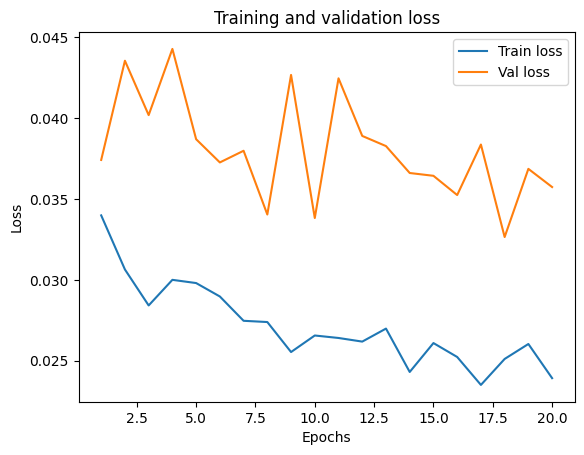

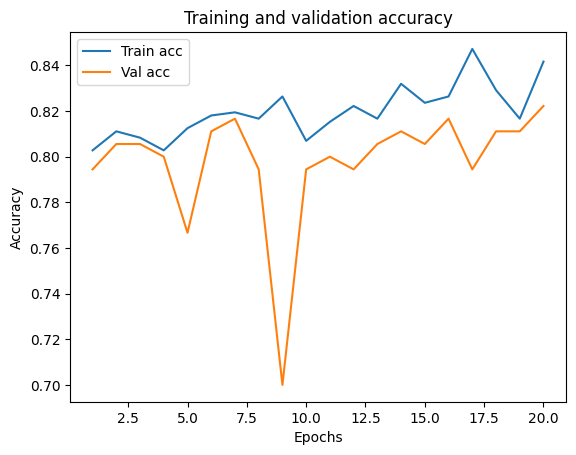

In [ ]:
### plot your training and test curves

import matplotlib.pyplot as plt

epochs = range(1, len(train_loss_record) + 1)
# loss
plt.figure()
plt.plot(epochs, train_loss_record, label='Train loss')
plt.plot(epochs, val_loss_record, label='Val loss')
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# accuracy
plt.figure()
plt.plot(epochs, train_acc_record, label='Train acc')
plt.plot(epochs, val_acc_record, label='Val acc')
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [ ]:
# To solve the imbalance problem, we can oversample the minority class.
from imblearn.over_sampling import RandomOverSampler
import os

# only need to sample the training data
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(loader_train.dataset.imgs, loader_train.dataset.targets)

new_root_train = "new_train"
os.makedirs(new_root_train, exist_ok=True)
# copy files
for i,x in enumerate(X_train_resampled):
    src = x[0]
    classname = src.split("/")[1]
    filename = f"{i}.jpg"
    dest = os.path.join(new_root_train, classname, filename) #target path
    os.makedirs(os.path.dirname(dest), exist_ok=True) #make class folder
    # move files
    !cp $src $dest

In [ ]:
from tqdm import tqdm
import numpy as np
import torch.nn as nn
from sklearn.metrics import roc_auc_score, accuracy_score

# new dataloader
train_dataset = ImageFolder(new_root_train, transform=train_transform)
loader_train_resampled = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
    )

# the following are almost the same
max_epoch = 20
use_cuda = torch.cuda.is_available()
if use_cuda:
    model = model.cuda()

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

best_val_loss = float('inf')
best_val_auc = 0
best_model = None
train_loss_record, train_acc_record, train_auc_record = [],[],[]
val_loss_record, val_acc_record, val_auc_record = [],[],[]
for epoch in range(max_epoch):
    print(" -- Epoch {}/{}".format(epoch + 1, max_epoch))

    ### training the model
    model.train()
    train_loss = 0
    y_true, y_pred = [], []
    for data in tqdm(loader_train_resampled): #train with the oversampled data
        # -- write your codes here
        inputs, labels = data
        if use_cuda:
          inputs, labels = inputs.cuda(), labels.cuda()

        optimizer.zero_grad()
        outputs = model(inputs)
        # print(labels.dtype)
        loss = criterion(outputs.view(-1), labels.float())
        train_loss += loss.item()
        if use_cuda:
          y_pred.extend(torch.round(torch.sigmoid(outputs.view(-1))).cpu().detach().numpy())
          y_true.extend(labels.cpu().numpy())
        else:
          y_pred.extend(torch.round(torch.sigmoid(outputs.view(-1))).detach().numpy())
          y_true.extend(labels.numpy())
        loss.backward()
        optimizer.step()

    ### record the training loss and metrics
    # -- write your codes here
    train_loss /= len(loader_train_resampled.dataset)
    train_loss_record.append(train_loss)
    auc = roc_auc_score(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    train_acc_record.append(acc)
    train_auc_record.append(auc)
    print(f"Epoch {epoch}: train_loss={train_loss}, train_auc={auc}, train_acc={acc}")

    ### evaluate on validation set
    model.eval()
    val_loss = 0
    y_true, y_pred = [], []
    for data in loader_val:
        # -- write your codes here
        inputs, labels = data
        if use_cuda:
          inputs, labels = inputs.cuda(), labels.cuda()
        with torch.no_grad():
          outputs = model(inputs)
          loss = criterion(outputs.view(-1), labels.float())
          val_loss += loss.item()
          if use_cuda:
            y_pred.extend(torch.round(torch.sigmoid(outputs.view(-1))).cpu().detach().numpy())
            y_true.extend(labels.cpu().numpy())
          else:
            y_pred.extend(torch.round(torch.sigmoid(outputs.view(-1))).detach().numpy())
            y_true.extend(labels.numpy())

    ### record the validation loss and metrics, save the best checkpoint
    # -- write your codes here
    val_loss /= len(loader_val.dataset)
    val_loss_record.append(val_loss)
    auc = roc_auc_score(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    val_acc_record.append(acc)
    val_auc_record.append(auc)
    print(f"--- val_loss={val_loss}, val_auc={auc}, val_acc={acc}")
    # if val_loss > best_val_loss:
    #   best_val_loss = val_loss
    if best_val_auc < auc:
      best_val_auc = auc
      best_model = model


### evaluate on test set
model.eval()
y_true, y_pred = [], []
for data in loader_test:
  # -- write your codes here
  inputs, labels = data
  if use_cuda:
    inputs, labels = inputs.cuda(), labels.cuda()
  with torch.no_grad():
    outputs = best_model(inputs)
    if use_cuda:
      y_pred.extend(torch.round(torch.sigmoid(outputs.view(-1))).cpu().detach().numpy())
      y_true.extend(labels.cpu().numpy())
    else:
      y_pred.extend(torch.round(torch.sigmoid(outputs.view(-1))).detach().numpy())
      y_true.extend(labels.numpy())

### compute and print the metrics on test set
# -- write your codes here
auc = roc_auc_score(y_true, y_pred)
acc = accuracy_score(y_true, y_pred)
print(f"test_auc={auc}, test_acc={acc}")


 -- Epoch 1/20


100%|██████████| 73/73 [00:36<00:00,  1.98it/s]


Epoch 0: train_loss=0.0501891756078222, train_auc=0.5472508591065293, train_acc=0.5472508591065293
--- val_loss=0.04172348313861423, val_auc=0.5142857142857143, val_acc=0.6888888888888889
 -- Epoch 2/20


100%|██████████| 73/73 [00:38<00:00,  1.92it/s]


Epoch 1: train_loss=0.045738506409310806, train_auc=0.5378006872852232, train_acc=0.5378006872852233
--- val_loss=0.048471890224350826, val_auc=0.529064039408867, val_acc=0.5555555555555556
 -- Epoch 3/20


100%|██████████| 73/73 [00:37<00:00,  1.92it/s]


Epoch 2: train_loss=0.046077948306843995, train_auc=0.5463917525773195, train_acc=0.5463917525773195
--- val_loss=0.1649327607618438, val_auc=0.5369458128078818, val_acc=0.28888888888888886
 -- Epoch 4/20


100%|██████████| 73/73 [00:37<00:00,  1.94it/s]


Epoch 3: train_loss=0.044730666884032315, train_auc=0.5609965635738831, train_acc=0.5609965635738832
--- val_loss=0.04420774396922853, val_auc=0.4763546798029557, val_acc=0.6277777777777778
 -- Epoch 5/20


100%|██████████| 73/73 [00:37<00:00,  1.96it/s]


Epoch 4: train_loss=0.04377965869772475, train_auc=0.5412371134020618, train_acc=0.5412371134020618
--- val_loss=0.042906937334272595, val_auc=0.4862068965517241, val_acc=0.6611111111111111
 -- Epoch 6/20


100%|██████████| 73/73 [00:36<00:00,  2.01it/s]


Epoch 5: train_loss=0.04413985878331555, train_auc=0.5532646048109966, train_acc=0.5532646048109966
--- val_loss=0.04610694646835327, val_auc=0.5137931034482758, val_acc=0.5833333333333334
 -- Epoch 7/20


100%|██████████| 73/73 [00:36<00:00,  1.99it/s]


Epoch 6: train_loss=0.04292468608859478, train_auc=0.5893470790378007, train_acc=0.5893470790378007
--- val_loss=0.051180735892719695, val_auc=0.5901477832512316, val_acc=0.4444444444444444
 -- Epoch 8/20


100%|██████████| 73/73 [00:37<00:00,  1.93it/s]


Epoch 7: train_loss=0.042597362547600805, train_auc=0.5867697594501718, train_acc=0.5867697594501718
--- val_loss=0.04466232938898934, val_auc=0.5241379310344827, val_acc=0.7222222222222222
 -- Epoch 9/20


100%|██████████| 73/73 [00:37<00:00,  1.93it/s]


Epoch 8: train_loss=0.042942822850037275, train_auc=0.5867697594501718, train_acc=0.5867697594501718
--- val_loss=0.04286819481187397, val_auc=0.5024630541871922, val_acc=0.6
 -- Epoch 10/20


100%|██████████| 73/73 [00:37<00:00,  1.96it/s]


Epoch 9: train_loss=0.04242439839438474, train_auc=0.5970790378006873, train_acc=0.5970790378006873
--- val_loss=0.05043294628461202, val_auc=0.5448275862068965, val_acc=0.5111111111111111
 -- Epoch 11/20


100%|██████████| 73/73 [00:37<00:00,  1.93it/s]


Epoch 10: train_loss=0.04382329052666208, train_auc=0.5369415807560137, train_acc=0.5369415807560137
--- val_loss=0.045353925228118895, val_auc=0.5403940886699506, val_acc=0.5388888888888889
 -- Epoch 12/20


100%|██████████| 73/73 [00:36<00:00,  1.99it/s]


Epoch 11: train_loss=0.042359811333856225, train_auc=0.5798969072164948, train_acc=0.5798969072164949
--- val_loss=0.03903278493218952, val_auc=0.6394088669950739, val_acc=0.7333333333333333
 -- Epoch 13/20


100%|██████████| 73/73 [00:36<00:00,  1.97it/s]


Epoch 12: train_loss=0.04126438723806663, train_auc=0.6005154639175257, train_acc=0.6005154639175257
--- val_loss=0.04367014335261451, val_auc=0.535960591133005, val_acc=0.5666666666666667
 -- Epoch 14/20


100%|██████████| 73/73 [00:37<00:00,  1.95it/s]


Epoch 13: train_loss=0.04215355678317473, train_auc=0.6108247422680413, train_acc=0.6108247422680413
--- val_loss=0.043183218273851603, val_auc=0.5876847290640395, val_acc=0.65
 -- Epoch 15/20


100%|██████████| 73/73 [00:38<00:00,  1.92it/s]


Epoch 14: train_loss=0.04000711773883846, train_auc=0.6374570446735396, train_acc=0.6374570446735395
--- val_loss=0.04714921911557515, val_auc=0.6009852216748768, val_acc=0.5666666666666667
 -- Epoch 16/20


100%|██████████| 73/73 [00:38<00:00,  1.91it/s]


Epoch 15: train_loss=0.04110361098014202, train_auc=0.6219931271477663, train_acc=0.6219931271477663
--- val_loss=0.04891131569941839, val_auc=0.5827586206896552, val_acc=0.5722222222222222
 -- Epoch 17/20


100%|██████████| 73/73 [00:37<00:00,  1.92it/s]


Epoch 16: train_loss=0.04175736035677985, train_auc=0.6039518900343643, train_acc=0.6039518900343642
--- val_loss=0.04146623313426971, val_auc=0.5157635467980296, val_acc=0.6388888888888888
 -- Epoch 18/20


100%|██████████| 73/73 [00:36<00:00,  1.99it/s]


Epoch 17: train_loss=0.041447890122321876, train_auc=0.6013745704467354, train_acc=0.6013745704467354
--- val_loss=0.04317016253868739, val_auc=0.5733990147783252, val_acc=0.6444444444444445
 -- Epoch 19/20


100%|██████████| 73/73 [00:36<00:00,  1.98it/s]


Epoch 18: train_loss=0.04113711531936508, train_auc=0.6202749140893471, train_acc=0.6202749140893471
--- val_loss=0.04302799718247519, val_auc=0.6118226600985222, val_acc=0.5666666666666667
 -- Epoch 20/20


100%|██████████| 73/73 [00:37<00:00,  1.93it/s]


Epoch 19: train_loss=0.04053560442121578, train_auc=0.6288659793814433, train_acc=0.6288659793814433
--- val_loss=0.045404125253359476, val_auc=0.5285714285714286, val_acc=0.5722222222222222
test_auc=0.6278289473684211, test_acc=0.5963060686015831


# Contrastive Learning

In [ ]:
import torch
from torch import nn, optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import numpy as np

from torchvision.models import resnet50

# Define a simple neural network as an encoder.
class SimpleEncoder(nn.Module):
    def __init__(self):
        super(SimpleEncoder, self).__init__()
        Resnet50 = ResNet(Bottleneck, [3, 4, 6, 3], dropout=None)
        pre_trained = resnet50(weights = "IMAGENET1K_V2").state_dict()
        new_weights = {k: pre_trained[k] for k in Resnet50.state_dict()}
        Resnet50.load_state_dict(new_weights)
        self.resnet = Resnet50
        # Freeze the weight of the pre-training model
        for param in self.resnet.parameters():
            param.requires_grad = False
        # Modify the last layer to output features.
        self.resnet.fc = nn.Identity()

    def forward(self, x):
        return self.resnet(x)

# Define projection head
class ProjectionHead(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ProjectionHead, self).__init__()
        self.projector = nn.Sequential(
            nn.Linear(input_dim, output_dim, bias=False),
            nn.ReLU(),
            nn.Linear(output_dim, output_dim, bias=False)
        )

    def forward(self, z):
        return self.projector(z)

# Define the contrast loss function
class ContrastiveLoss(nn.Module):
    def __init__(self, temperature=0.5):
        super(ContrastiveLoss, self).__init__()
        self.temperature = temperature

    def forward(self, output1, output2, labels=None):
        # output1 and output2 are the feature representations of the same picture after two enhancements.
        # label used to ensure a positive sample pair.
        if labels is not None:
            labels = labels[:, np.newaxis]
        inf = torch.tensor(np.inf)
        if torch.cuda.is_available():
            inf = inf.cuda()

        # Calculate the similarity between point pairs
        dot_product = torch.div(torch.matmul(output1, output2.transpose(1, 0)), self.temperature)
        # The diagonal part is the similarity between itself, which is set to infinity.
        dot_product = torch.where(torch.eq(labels, labels.transpose(1, 0)), -inf, dot_product)

        # Use softmax to get the probability of each positive sample pair.
        sim = torch.exp(dot_product)
        sim = sim / torch.sum(sim, dim=1, keepdim=True)

        # Calculate the contrast loss
        loss = - torch.sum(torch.log(sim), dim=1).mean()
        return loss


# Contrastive loss (NT-Xent)
class NTXentLoss(nn.Module):
    def __init__(self, temperature=0.5):
        super(NTXentLoss, self).__init__()
        self.temperature = temperature
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, z_i, z_j):
        N, Z = z_i.size()
        z = torch.cat([z_i, z_j], dim=0)
        sim = torch.mm(z, z.t()) / self.temperature

        labels = torch.cat([torch.arange(N) for _ in range(2)], dim=0).to(z.device)
        mask = torch.eye(2 * N, device=z.device).bool()
        sim = sim.masked_fill(mask, float('-inf'))
        targets = torch.cat([torch.arange(N) + N, torch.arange(N)], dim=0).to(z.device)

        return self.criterion(sim, targets)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate data enhancement, encoder, projection head and loss function
encoder = SimpleEncoder().to(device)
projector = ProjectionHead(input_dim=2048, output_dim=128).to(device)  # Adjust according to the characteristic dimension of ResNet50
#criterion = ContrastiveLoss()
criterion = NTXentLoss()

root_train, root_val, root_test = "train/", "val/", "test/"# -- write your codes here: the root path of training/validation/test set


SimCLRDataAugmentation = transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


test_transform = transforms.Compose([
    # -- write your codes here: data preprocessing
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Prepare data set
train_dataset = datasets.ImageFolder(root_train, transform=SimCLRDataAugmentation)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Define optimizer
optimizer = optim.Adam(list(encoder.parameters()) + list(projector.parameters()), lr=2e-5)

num_epochs = 30

# Training model
for epoch in range(num_epochs):
    train_loss = 0
    for (img1, _), (img2, _) in tqdm(zip(train_loader, train_loader), total=len(train_loader)):
        # Enhanced each image twice with different data.
        img1 = img1.to(device)
        img2 = img2.to(device)

        # Obtaining feature representation through encoder and projection head
        z1 = encoder(img1)
        z2 = encoder(img2)

        # Get the feature representation after projection
        z1 = projector(z1)
        z2 = projector(z2)

        # Calculate the contrast loss
        loss = criterion(z1, z2)# labels=torch.arange(img1.size(0)).to(img1.device))

        # Back Propagation and Optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader.dataset)

    print(f"Epoch: {epoch+1}, Loss: {train_loss}")

# Save model
torch.save(encoder.state_dict(), 'encoder.pth')
torch.save(projector.state_dict(), 'projector.pth')




100%|██████████| 45/45 [01:02<00:00,  1.38s/it]


Epoch: 1, Loss: 0.21468003789583842


100%|██████████| 45/45 [00:58<00:00,  1.30s/it]


Epoch: 2, Loss: 0.21456740299860635


100%|██████████| 45/45 [00:58<00:00,  1.30s/it]


Epoch: 3, Loss: 0.2142985029353036


100%|██████████| 45/45 [00:58<00:00,  1.29s/it]


Epoch: 4, Loss: 0.21434034605820973


100%|██████████| 45/45 [00:58<00:00,  1.30s/it]


Epoch: 5, Loss: 0.21436239414744906


100%|██████████| 45/45 [00:58<00:00,  1.30s/it]


Epoch: 6, Loss: 0.21432061758306292


100%|██████████| 45/45 [00:58<00:00,  1.30s/it]


Epoch: 7, Loss: 0.21465710136625502


100%|██████████| 45/45 [00:58<00:00,  1.31s/it]


Epoch: 8, Loss: 0.21422468821207682


100%|██████████| 45/45 [00:57<00:00,  1.29s/it]


Epoch: 9, Loss: 0.2145176847775777


100%|██████████| 45/45 [00:57<00:00,  1.29s/it]


Epoch: 10, Loss: 0.21461598575115204


100%|██████████| 45/45 [00:57<00:00,  1.29s/it]


Epoch: 11, Loss: 0.21405464708805083


100%|██████████| 45/45 [00:58<00:00,  1.30s/it]


Epoch: 12, Loss: 0.21475197275479635


100%|██████████| 45/45 [00:58<00:00,  1.30s/it]


Epoch: 13, Loss: 0.21428579654958513


100%|██████████| 45/45 [00:58<00:00,  1.30s/it]


Epoch: 14, Loss: 0.21405693259504105


100%|██████████| 45/45 [00:58<00:00,  1.30s/it]


Epoch: 15, Loss: 0.2141194330321418


100%|██████████| 45/45 [00:58<00:00,  1.29s/it]


Epoch: 16, Loss: 0.21437331868542564


100%|██████████| 45/45 [00:58<00:00,  1.29s/it]


Epoch: 17, Loss: 0.2143738200267156


100%|██████████| 45/45 [00:59<00:00,  1.31s/it]


Epoch: 18, Loss: 0.2145037137799793


100%|██████████| 45/45 [00:58<00:00,  1.29s/it]


Epoch: 19, Loss: 0.21439591811762915


100%|██████████| 45/45 [00:57<00:00,  1.28s/it]


Epoch: 20, Loss: 0.21386356221305


100%|██████████| 45/45 [00:57<00:00,  1.29s/it]


Epoch: 21, Loss: 0.21426462431748708


100%|██████████| 45/45 [00:57<00:00,  1.28s/it]


Epoch: 22, Loss: 0.21430477665530312


100%|██████████| 45/45 [00:58<00:00,  1.30s/it]


Epoch: 23, Loss: 0.2143259541855918


100%|██████████| 45/45 [00:57<00:00,  1.27s/it]


Epoch: 24, Loss: 0.21444543898105622


100%|██████████| 45/45 [00:56<00:00,  1.27s/it]


Epoch: 25, Loss: 0.2146455983320872


100%|██████████| 45/45 [00:56<00:00,  1.27s/it]


Epoch: 26, Loss: 0.2143938034772873


100%|██████████| 45/45 [00:56<00:00,  1.26s/it]


Epoch: 27, Loss: 0.2141686803764767


100%|██████████| 45/45 [00:56<00:00,  1.26s/it]


Epoch: 28, Loss: 0.21441735393471187


100%|██████████| 45/45 [00:56<00:00,  1.27s/it]


Epoch: 29, Loss: 0.21438528531127507


100%|██████████| 45/45 [00:58<00:00,  1.30s/it]


Epoch: 30, Loss: 0.21436272660891215


## Test

In [ ]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


# 加载SimCLR预训练得到的权重，注意只需要加载特征提取器的权重
pretrained_weights = torch.load('encoder.pth')
# model.resnet.load_state_dict(pretrained_weights, strict=False)
Resnet50 = ResNet(Bottleneck, [3, 4, 6, 3], dropout=None)
Resnet50.load_state_dict(pretrained_weights, strict=False)
model = ClassificationModel(Resnet50, 1)

max_epoch = 20
use_cuda = torch.cuda.is_available()
if use_cuda:
    model = model.cuda()

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

best_val_loss = float('inf')
best_val_auc = 0
best_model = None
train_loss_record, train_acc_record, train_auc_record = [],[],[]
val_loss_record, val_acc_record, val_auc_record = [],[],[]
for epoch in range(max_epoch):
    print(" -- Epoch {}/{}".format(epoch + 1, max_epoch))

    ### training the model
    model.train()
    train_loss = 0
    y_true, y_pred = [], []
    for data in tqdm(loader_train_resampled): #train with the oversampled data
        # -- write your codes here
        inputs, labels = data
        if use_cuda:
          inputs, labels = inputs.cuda(), labels.cuda()

        optimizer.zero_grad()
        outputs = model(inputs)
        # print(labels.dtype)
        loss = criterion(outputs.view(-1), labels.float())
        train_loss += loss.item()
        if use_cuda:
          y_pred.extend(torch.round(torch.sigmoid(outputs.view(-1))).cpu().detach().numpy())
          y_true.extend(labels.cpu().numpy())
        else:
          y_pred.extend(torch.round(torch.sigmoid(outputs.view(-1))).detach().numpy())
          y_true.extend(labels.numpy())
        loss.backward()
        optimizer.step()

    ### record the training loss and metrics
    # -- write your codes here
    train_loss /= len(loader_train_resampled.dataset)
    train_loss_record.append(train_loss)
    auc = roc_auc_score(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    train_acc_record.append(acc)
    train_auc_record.append(auc)
    print(f"Epoch {epoch}: train_loss={train_loss}, train_auc={auc}, train_acc={acc}")

    ### evaluate on validation set
    model.eval()
    val_loss = 0
    y_true, y_pred = [], []
    for data in loader_val:
        # -- write your codes here
        inputs, labels = data
        if use_cuda:
          inputs, labels = inputs.cuda(), labels.cuda()
        with torch.no_grad():
          outputs = model(inputs)
          loss = criterion(outputs.view(-1), labels.float())
          val_loss += loss.item()
          if use_cuda:
            y_pred.extend(torch.round(torch.sigmoid(outputs.view(-1))).cpu().detach().numpy())
            y_true.extend(labels.cpu().numpy())
          else:
            y_pred.extend(torch.round(torch.sigmoid(outputs.view(-1))).detach().numpy())
            y_true.extend(labels.numpy())

    ### record the validation loss and metrics, save the best checkpoint
    # -- write your codes here
    val_loss /= len(loader_val.dataset)
    val_loss_record.append(val_loss)
    auc = roc_auc_score(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    val_acc_record.append(acc)
    val_auc_record.append(auc)
    print(f"--- val_loss={val_loss}, val_auc={auc}, val_acc={acc}")
    # if val_loss > best_val_loss:
    #   best_val_loss = val_loss
    if best_val_auc < auc:
      best_val_auc = auc
      best_model = model


### evaluate on test set
model.eval()
y_true, y_pred = [], []
for data in loader_test:
  # -- write your codes here
  inputs, labels = data
  if use_cuda:
    inputs, labels = inputs.cuda(), labels.cuda()
  with torch.no_grad():
    outputs = model(inputs)
    if use_cuda:
      y_pred.extend(torch.round(torch.sigmoid(outputs.view(-1))).cpu().detach().numpy())
      y_true.extend(labels.cpu().numpy())
    else:
      y_pred.extend(torch.round(torch.sigmoid(outputs.view(-1))).detach().numpy())
      y_true.extend(labels.numpy())

### compute and print the metrics on test set
# -- write your codes here
auc = roc_auc_score(y_true, y_pred)
acc = accuracy_score(y_true, y_pred)
print(f"test_auc={auc}, test_acc={acc}")

 -- Epoch 1/20


100%|██████████| 73/73 [00:39<00:00,  1.87it/s]


Epoch 0: train_loss=0.044160509283599984, train_auc=0.5214776632302405, train_acc=0.5214776632302406
--- val_loss=0.04235044618447622, val_auc=0.5004926108374383, val_acc=0.7888888888888889
 -- Epoch 2/20


100%|██████████| 73/73 [00:39<00:00,  1.86it/s]


Epoch 1: train_loss=0.042801045572634824, train_auc=0.5584192439862543, train_acc=0.5584192439862543
--- val_loss=0.04844321062167486, val_auc=0.5733990147783251, val_acc=0.5222222222222223
 -- Epoch 3/20


100%|██████████| 73/73 [00:38<00:00,  1.91it/s]


Epoch 2: train_loss=0.04281133669348517, train_auc=0.5678694158075601, train_acc=0.5678694158075601
--- val_loss=0.04384964009126027, val_auc=0.5729064039408868, val_acc=0.6611111111111111
 -- Epoch 4/20


100%|██████████| 73/73 [00:39<00:00,  1.87it/s]


Epoch 3: train_loss=0.042192739309723844, train_auc=0.5764604810996563, train_acc=0.5764604810996563
--- val_loss=0.048033711976475185, val_auc=0.5502463054187192, val_acc=0.45
 -- Epoch 5/20


100%|██████████| 73/73 [00:38<00:00,  1.89it/s]


Epoch 4: train_loss=0.04066966258987938, train_auc=0.609106529209622, train_acc=0.6091065292096219
--- val_loss=0.0394462635119756, val_auc=0.6492610837438423, val_acc=0.7666666666666667
 -- Epoch 6/20


100%|██████████| 73/73 [00:38<00:00,  1.89it/s]


Epoch 5: train_loss=0.04100212879811775, train_auc=0.6194158075601375, train_acc=0.6194158075601375
--- val_loss=0.061905461549758914, val_auc=0.5793103448275863, val_acc=0.4444444444444444
 -- Epoch 7/20


100%|██████████| 73/73 [00:37<00:00,  1.97it/s]


Epoch 6: train_loss=0.040430996733432784, train_auc=0.6228522336769758, train_acc=0.622852233676976
--- val_loss=0.03916471650203069, val_auc=0.6334975369458127, val_acc=0.6888888888888889
 -- Epoch 8/20


100%|██████████| 73/73 [00:38<00:00,  1.89it/s]


Epoch 7: train_loss=0.03991438783833252, train_auc=0.6245704467353952, train_acc=0.6245704467353952
--- val_loss=0.05620698630809784, val_auc=0.5620689655172414, val_acc=0.4166666666666667
 -- Epoch 9/20


100%|██████████| 73/73 [00:38<00:00,  1.90it/s]


Epoch 8: train_loss=0.03958454108524978, train_auc=0.6529209621993126, train_acc=0.6529209621993127
--- val_loss=0.056980191005600825, val_auc=0.6049261083743842, val_acc=0.43333333333333335
 -- Epoch 10/20


100%|██████████| 73/73 [00:38<00:00,  1.89it/s]


Epoch 9: train_loss=0.03925824598041187, train_auc=0.6383161512027491, train_acc=0.6383161512027491
--- val_loss=0.03910361015134388, val_auc=0.5615763546798029, val_acc=0.6777777777777778
 -- Epoch 11/20


100%|██████████| 73/73 [00:38<00:00,  1.89it/s]


Epoch 10: train_loss=0.039151745051452795, train_auc=0.6469072164948454, train_acc=0.6469072164948454
--- val_loss=0.05140806155072318, val_auc=0.6536945812807882, val_acc=0.49444444444444446
 -- Epoch 12/20


100%|██████████| 73/73 [00:38<00:00,  1.89it/s]


Epoch 11: train_loss=0.03902158988607708, train_auc=0.6374570446735395, train_acc=0.6374570446735395
--- val_loss=0.043952953981028664, val_auc=0.6389162561576354, val_acc=0.6277777777777778
 -- Epoch 13/20


100%|██████████| 73/73 [00:38<00:00,  1.87it/s]


Epoch 12: train_loss=0.03849390405150214, train_auc=0.6486254295532646, train_acc=0.6486254295532646
--- val_loss=0.04908978740374247, val_auc=0.570935960591133, val_acc=0.48333333333333334
 -- Epoch 14/20


100%|██████████| 73/73 [00:38<00:00,  1.91it/s]


Epoch 13: train_loss=0.03879716754266896, train_auc=0.6331615120274915, train_acc=0.6331615120274914
--- val_loss=0.05569880604743958, val_auc=0.6344827586206897, val_acc=0.5333333333333333
 -- Epoch 15/20


100%|██████████| 73/73 [00:39<00:00,  1.84it/s]


Epoch 14: train_loss=0.03744115091578657, train_auc=0.654639175257732, train_acc=0.654639175257732
--- val_loss=0.037685191962454054, val_auc=0.5704433497536945, val_acc=0.7444444444444445
 -- Epoch 16/20


100%|██████████| 73/73 [00:38<00:00,  1.87it/s]


Epoch 15: train_loss=0.03871302104385448, train_auc=0.63659793814433, train_acc=0.6365979381443299
--- val_loss=0.039565905928611755, val_auc=0.5763546798029557, val_acc=0.6666666666666666
 -- Epoch 17/20


100%|██████████| 73/73 [00:39<00:00,  1.85it/s]


Epoch 16: train_loss=0.03801658191426923, train_auc=0.6443298969072164, train_acc=0.6443298969072165
--- val_loss=0.041697995199097525, val_auc=0.6339901477832512, val_acc=0.6722222222222223
 -- Epoch 18/20


100%|██████████| 73/73 [00:39<00:00,  1.87it/s]


Epoch 17: train_loss=0.03863294647936149, train_auc=0.654639175257732, train_acc=0.654639175257732
--- val_loss=0.044950638959805174, val_auc=0.5847290640394088, val_acc=0.6277777777777778
 -- Epoch 19/20


100%|██████████| 73/73 [00:39<00:00,  1.86it/s]


Epoch 18: train_loss=0.038069424043406325, train_auc=0.6554982817869416, train_acc=0.6554982817869416
--- val_loss=0.04338726898034414, val_auc=0.6, val_acc=0.6
 -- Epoch 20/20


100%|██████████| 73/73 [00:38<00:00,  1.89it/s]


Epoch 19: train_loss=0.03703537368282829, train_auc=0.6804123711340206, train_acc=0.6804123711340206
--- val_loss=0.04809591389364666, val_auc=0.6507389162561577, val_acc=0.5944444444444444
test_auc=0.6944956140350877, test_acc=0.6226912928759895
